<a href="https://colab.research.google.com/github/NatalyaEvans/ETNP_stoich/blob/main/pyompa_scripts/ETNP_pyompa_for_WOD_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script first performs an eOMP on the ETNP ODZ data from the WOD18 usung the core endmembers. Next, it generates a range of potential endmember nutrient concentrations, based on remineralization stoichiometry, and performs eOMP on all of them too. These calculations are performed because the nitrate anaerobic slope is sensitive to endmember nutrient concentrations. 

Mount the google drive folder


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install pyompa and gsw

In [56]:
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
%cd "/content/drive/MyDrive/USC drive/pyompa/ETNP WOD pyompa"
!ls

/content/drive/MyDrive/USC drive/pyompa/ETNP WOD pyompa
CCHDO.csv
endmember_sensitivity_fns.ipynb
ETNP_df_ompasoln.csv
ETNP_df_ompasoln_super_wide_anaerob.csv
ETNP_df_ompasoln_test.csv
ETNP_df_ompasoln_wide_anaerob.csv
ETNP_pyompa_for_WOD_base_tweaks.ipynb
ETNP_pyompa_for_WOD_full_version.ipynb
ETNP_pyompa_for_WOD_with_weightings_sensitivity.ipynb
ETNP_pyompa_ref_values.csv
mean_skeleton_endmembers.csv
mean_skeleton_weightings.csv
param_weightings_sensitivity
pyompa_basis.m
pyompa_plotter_reox.m
sampled_weightings.json
scratch
std_skeleton_endmembers.csv
std_skeleton_weightings.csv
WOD_cleaned.csv
WOD_ETNP_pyompa_2.csv
WOD_ETNP_pyompa_2_reduced.csv



Load the input data

In [58]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import json
from collections import OrderedDict



In [60]:
inp_df = pd.read_csv("CCHDO.csv") # read in the data to be analyzed. This data file already has the values outside of the analysis region removed
data_df = pd.DataFrame(
   inp_df[(inp_df["pdens"] >= 26.4)
              & (inp_df["pdens"] <= 27.2)
              & (inp_df["LATITUDE"] >= 10)])
data_df.size
data_df.head() 

EXPOCODE SECT_ID  STNNBR  CASTNO  SAMPNO  BTLNBR  BTLNBR_FLAG_W  \
344  31DSCG94_3    P18N     168       3     328    1032              2   
345  31DSCG94_3    P18N     168       3     327    1008              2   
346  31DSCG94_3    P18N     168       3     326    1007              2   
347  31DSCG94_3    P18N     168       3     325    1256              2   
348  31DSCG94_3    P18N     168       3     323    1220              2   

         DATE  TIME  LATITUDE  ...  DELC13  DELC13_FLAG_W    tCO2  \
344  19940419  1727   10.0002  ...    -0.1              2  2245.2   
345  19940419  1727   10.0002  ...    -0.1              2  2249.1   
346  19940419  1727   10.0002  ...     0.0              2  2246.7   
347  19940419  1727   10.0002  ...    -0.1              2  2262.4   
348  19940419  1727   10.0002  ...    -0.1              2  2277.6   

     TCARBN_FLAG_W  ALKALI  ALKALI_FLAG_W  PH_TMP         SA         CT  \
344              2  2294.0              2      25  34.942229  11.852994   
345              2  2299.0              2      25  34.916458  11.246889   
346              2  2302.0              2      25  34.895094  10.725307   
347              2  2297.0              2      25  34.869706  10.261885   
348              2  2309.0              2      25  34.844701   9.764902   

         pdens  
344  26.446539  
345  26.539512  
346  26.617157  
347  26.678843  
348  26.744219  

[5 rows x 46 columns]

Define the end-members. Column headers here have to match those of the observations pandas

In [61]:
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")


In [62]:
endmembers_df_read.head()

Params      CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.410  34.95      2.355    31.20     25.40  2235  26.29   
1  NEPIW   9.470  34.78      2.650    35.60     33.86  2273  26.74   
2   AAIW   5.530  34.70      3.130    43.21     76.00  2321  27.25   
3  uPSUW   7.765  32.96      1.130    10.07     11.40  2235  25.60   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...  
3                                                NaN

Remove the non-water types from the endmembers

In [63]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # use uPSUW or no fourth

endmembers_df.head()

Params     CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.41  34.95      2.355    31.20     25.40  2235  26.29   
1  NEPIW   9.47  34.78      2.650    35.60     33.86  2273  26.74   
2   AAIW   5.53  34.70      3.130    43.21     76.00  2321  27.25   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...

Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [64]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc

convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"Phosphate": 1.0, "Nitrate": 13, "Silicate": 14, "tCO2": 96},
        {"Phosphate": 1.0, "Nitrate": 17, "Silicate": 30, "tCO2": 116}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[
        {"Phosphate": 1.0, "Nitrate": -35, "Silicate": 14, "tCO2": 96},
        {"Phosphate": 1.0, "Nitrate": -61, "Silicate": 30, "tCO2": 116}  
        ],
        always_positive=True 
        )
]

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            # {'type':'exp_density_default', 'lowerbound':26.7}})
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "CT": 14.0,
    "SA": 10.0,
    "Phosphate": 8.0,
    "Nitrate":8.0,
    "tCO2": 4.0,
    "Silicate": 2.0
}

settings = {
    "param_names": ["CT", "SA",
                    "Phosphate", "Nitrate",
                    "Silicate"
                    ,"tCO2"
                    ],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False}

#Run the analysis, replicating the MATLAB OMP analysis
ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Params")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs nto a dictionary

Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [14. 10.  8.  8.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 457 out of 457
status: optimal
optimal value 2384033.206868927
Original weighted sum squares: 2384033.04522486
Post fix weighted sum squared: 2384033.4710884853
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 457 out of 457
status: optimal
optimal value 252931.49770685163
Original weighted sum squares: 252931.2178073006
Post fix weighted sum squared: 252944.39115768104
On example 0 to 457 out of 457
status: optimal
optimal value 133277.5406458167
Original weighted sum squares: 133277.37186577043
Post fix weighted sum squared: 133277.9488308555
objective: 133277.94883085552



Load in plotting tools

In [65]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and respiration


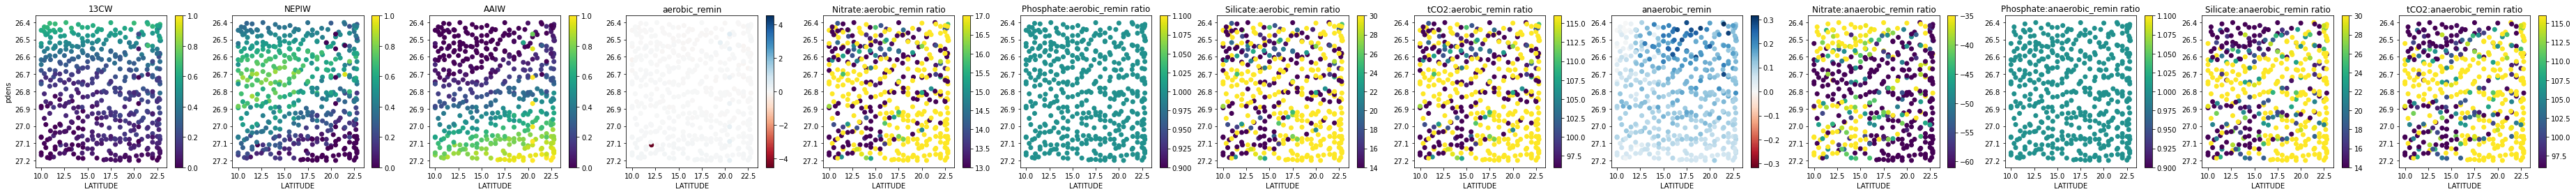

In [66]:
xaxis_colname="LATITUDE"

yaxis_colname = "pdens"
print("Water mass fractions and respiration")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


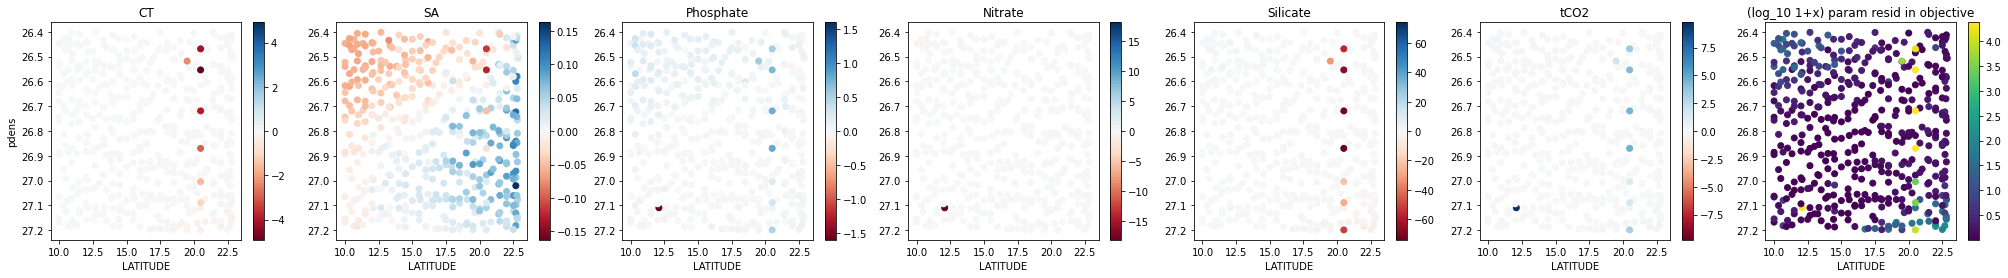

In [67]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n




In [68]:

# ORIG_COLS_TO_INCLUDE = ["lat", "long", "pdens", "pressure", "nitrate", "oxygen", "phosphate",'conservative_temp', 'absolute_salinity']
ORIG_COLS_TO_INCLUDE = list(data_df.columns.values)
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)


writing to ETNP_df_ompasoln.csv


In [69]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

Found existing installation: gp15wma 0.1.0.0
Uninstalling gp15wma-0.1.0.0:
  Successfully uninstalled gp15wma-0.1.0.0
/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 248 (delta 13), reused 3 (delta 3), pack-reused 226
Receiving objects: 100% (248/248), 16.42 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit 0f8be9e53d4dfdb510bd26abfe98a12fce38a942 (HEAD -> main, origin/main, origin/HEAD)
Author: rml54 <45828236+rml54@users.noreply.github.com>
Date:   Mon Apr 18 17:02:17 2022 -0400

    Update funcdump.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gp15wmascripts
  Preparing metadata (setup.py) ... done
  Created wheel for gp15wma: filename=gp15wma-0.1.0.0-py3-none

/content


<module 'gp15wma' from '/usr/local/lib/python3.8/dist-packages/gp15wma/__init__.py'>

In [70]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments

from gp15wma.sensitivity import get_mean_and_stdev_skeletons


In [71]:
# print("mean")

def plot_ompasoln_residuals2(ompa_soln, xaxis_colname,
                             yaxis_colname, flip_y=True):
  pyompa.plotting.plot_residuals(
          param_residuals=ompa_soln.param_residuals,
          param_names=ompa_soln.param_names,
          xaxis_vals=ompa_soln.obs_df[xaxis_colname],
          xaxis_label=xaxis_colname,
          yaxis_vals=ompa_soln.obs_df[yaxis_colname],
          yaxis_label=yaxis_colname, flip_y=flip_y,
          perobs_weighted_resid_sq=None)


In [73]:
def perturb_endmember_df(df, variation_range, rng):
  new_df = OrderedDict([
      ("Params", df["Params"]) #endmember name column
  ])
  params_to_perturb = ["CT", "SA", "Phosphate", "Nitrate", "Silicate", "tCO2"]
  for param_name in params_to_perturb:
    values = list(df[param_name])
    new_values = [rng.uniform(value-variation_range[param_name],
                              value+variation_range[param_name])
                  for value in values]
    new_df[param_name] = new_values

  return pd.DataFrame(new_df)


def perturb_endmember_df_stoichiometrically(df, stoichiometry, rng,
                                            perturbation_limits_0, 
                                            scale_factor):
  #in Talia's project, pertubation_limits corresponds to phosphate which
  # has ratio 1 wrt to the converted param
  
  new_df = OrderedDict([
      ("Params", df["Params"]), #endmember name column and params that are carried through
      ("CT", df["CT"]),
      ("SA", df["SA"]),
  ])

  params_to_perturb = ["Phosphate", "Nitrate", "Silicate", "tCO2"]

  # print(sampled_perturbations)
  for param_name in params_to_perturb:
    values = list(df[param_name])

    # sample a different perturbation for each row in the data frame
    sampled_perturbations_0 = [rng.uniform(perturbation_limits_0[0], # remin 1
                                    perturbation_limits_0[1])
                              for i in range(len(df))]
    sampled_perturbations_1 = [rng.uniform(perturbation_limits_0[0]*scale_factor, # remin 2
                                       perturbation_limits_0[1]*scale_factor)
                                for i in range(len(df))]

    new_values = [value + sampled_perturbation0*(stoichiometry[0].conversion_ratios[0][param_name] +
                        stoichiometry[0].conversion_ratios[1][param_name])/2
                        for sampled_perturbation0, value in
                        zip(sampled_perturbations_0, values)]
                  
    new_values2 = [value + sampled_perturbation1*(stoichiometry[1].conversion_ratios[0][param_name] +
                        stoichiometry[1].conversion_ratios[1][param_name])/2
                        for sampled_perturbation1, value in
                        zip(sampled_perturbations_1, new_values)]

    new_df[param_name] = new_values2


  return pd.DataFrame(new_df)


Sensitivity with regards to endmembers

In [74]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 30
base_endmembers = endmembers_df

#sample varying parameter weightings
sampled_endmembers = []
for i in range(num_samples):
    sampled_endmembers.append(perturb_endmember_df_stoichiometrically(
    endmembers_df,
    # stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    stoichiometry=convertedparamgroups,
    perturbation_limits_0=(-0.075, 0.075),
    scale_factor=1/3,
    rng=rng))
    print("Iteration:", i)
    display(sampled_endmembers[-1])

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmembers]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "param_weightings": paramweightings,
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir endmembers_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmembers_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})

Iteration: 0


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.322996  29.794806  26.072743  2239.949543
1  NEPIW   9.47  34.78   2.682315  36.620451  34.565308  2276.833516
2   AAIW   5.53  34.70   3.109289  44.238425  75.036973  2318.156454

Iteration: 1


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.434408  32.885496  24.922262  2227.979493
1  NEPIW   9.47  34.78   2.663549  34.966164  34.777853  2273.360225
2   AAIW   5.53  34.70   3.117985  43.398837  75.461780  2322.830129

Iteration: 2


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.334810  30.283248  24.356571  2232.213928
1  NEPIW   9.47  34.78   2.653742  35.426152  34.142774  2281.928048
2   AAIW   5.53  34.70   3.047122  43.162965  75.436971  2315.483398

Iteration: 3


Params     CT     SA  Phosphate    Nitrate  Silicate         tCO2
0   13CW  13.41  34.95   2.370743  29.819812  26.44390  2231.868480
1  NEPIW   9.47  34.78   2.586907  34.147768  32.85155  2273.983617
2   AAIW   5.53  34.70   3.091175  42.766242  76.74415  2321.462332

Iteration: 4


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.369003  32.714775  23.789397  2239.344920
1  NEPIW   9.47  34.78   2.711236  36.858809  35.301265  2271.196110
2   AAIW   5.53  34.70   3.073973  44.032788  75.887277  2319.677939

Iteration: 5


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.393957  31.897128  26.165289  2234.222432
1  NEPIW   9.47  34.78   2.699569  36.378824  33.701425  2276.615213
2   AAIW   5.53  34.70   3.154444  42.032864  74.568570  2313.500184

Iteration: 6


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.274838  33.207666  26.338497  2243.879036
1  NEPIW   9.47  34.78   2.627574  35.314687  34.899462  2279.439564
2   AAIW   5.53  34.70   3.152916  41.982273  76.741581  2328.589368

Iteration: 7


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.406887  29.836330  26.038469  2232.000922
1  NEPIW   9.47  34.78   2.712144  35.450061  33.777453  2277.415143
2   AAIW   5.53  34.70   3.162583  42.424390  76.607913  2318.630397

Iteration: 8


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.299202  30.965385  26.075237  2229.231631
1  NEPIW   9.47  34.78   2.690780  36.296058  34.335314  2277.838168
2   AAIW   5.53  34.70   3.054210  43.254670  74.304055  2320.463344

Iteration: 9


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.371177  31.836963  24.652876  2234.771633
1  NEPIW   9.47  34.78   2.630937  36.781086  33.875815  2271.897183
2   AAIW   5.53  34.70   3.102679  43.565662  75.065915  2318.578625

Iteration: 10


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.285240  29.354251  25.783569  2237.773397
1  NEPIW   9.47  34.78   2.561618  36.337772  31.987535  2272.508916
2   AAIW   5.53  34.70   3.066126  41.514951  76.543358  2324.584933

Iteration: 11


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.407089  31.950577  26.790999  2236.114114
1  NEPIW   9.47  34.78   2.702013  35.456412  33.959922  2269.753985
2   AAIW   5.53  34.70   3.167089  42.132445  74.242942  2323.226947

Iteration: 12


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.425524  30.743870  24.775054  2229.122921
1  NEPIW   9.47  34.78   2.636721  34.910400  35.496232  2274.150019
2   AAIW   5.53  34.70   3.117684  44.367004  75.442361  2327.076537

Iteration: 13


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.279786  31.820680  26.294150  2230.524485
1  NEPIW   9.47  34.78   2.600479  35.443899  31.897047  2271.179600
2   AAIW   5.53  34.70   3.092896  43.914131  76.449400  2318.574577

Iteration: 14


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.433131  31.781268  25.010868  2229.879803
1  NEPIW   9.47  34.78   2.657829  35.247870  32.706606  2276.964367
2   AAIW   5.53  34.70   3.206770  43.350657  76.682567  2326.719068

Iteration: 15


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.350274  30.710281  23.532640  2235.138742
1  NEPIW   9.47  34.78   2.655352  35.706720  34.003892  2273.443158
2   AAIW   5.53  34.70   3.118101  43.827413  76.092074  2322.142740

Iteration: 16


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.331269  32.415787  25.096558  2229.630125
1  NEPIW   9.47  34.78   2.672548  33.840960  35.424925  2268.741112
2   AAIW   5.53  34.70   3.073102  41.281991  75.342286  2320.266173

Iteration: 17


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.375521  30.074664  25.534624  2230.046546
1  NEPIW   9.47  34.78   2.700171  35.600761  35.334533  2278.214212
2   AAIW   5.53  34.70   3.113225  44.827606  77.711418  2316.946439

Iteration: 18


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.406690  32.463220  25.922270  2234.438969
1  NEPIW   9.47  34.78   2.560320  36.904972  32.534217  2279.189758
2   AAIW   5.53  34.70   3.163964  44.480594  76.023772  2329.028979

Iteration: 19


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.321643  30.421816  25.948207  2230.280700
1  NEPIW   9.47  34.78   2.703510  36.497859  32.376339  2271.117535
2   AAIW   5.53  34.70   3.126785  43.617494  75.166085  2315.827605

Iteration: 20


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.312858  30.268513  24.634406  2230.641758
1  NEPIW   9.47  34.78   2.720280  35.550646  34.638791  2275.420625
2   AAIW   5.53  34.70   3.095499  42.721952  75.464636  2325.171658

Iteration: 21


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.287138  32.681267  24.591155  2232.521569
1  NEPIW   9.47  34.78   2.718801  36.669266  34.025256  2272.096318
2   AAIW   5.53  34.70   3.049494  43.084011  74.830310  2326.449024

Iteration: 22


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.400967  31.441102  23.710838  2235.955273
1  NEPIW   9.47  34.78   2.681695  35.644590  32.286309  2264.224999
2   AAIW   5.53  34.70   3.141668  41.978939  75.310502  2324.402360

Iteration: 23


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.327213  31.936096  24.832018  2232.250600
1  NEPIW   9.47  34.78   2.741998  33.862509  34.231196  2278.416778
2   AAIW   5.53  34.70   3.187469  42.998744  75.865292  2322.763918

Iteration: 24


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.406213  31.401195  26.003846  2232.804036
1  NEPIW   9.47  34.78   2.627920  36.132301  32.679995  2271.263058
2   AAIW   5.53  34.70   3.090903  42.985517  76.678039  2318.381559

Iteration: 25


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.427501  31.625506  25.445077  2232.163539
1  NEPIW   9.47  34.78   2.657533  35.201966  34.128451  2273.481670
2   AAIW   5.53  34.70   3.087679  42.142959  76.749372  2325.570595

Iteration: 26


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.406713  31.418681  24.414102  2243.205573
1  NEPIW   9.47  34.78   2.608364  33.970564  31.750235  2277.110346
2   AAIW   5.53  34.70   3.074795  42.407600  75.168008  2315.856662

Iteration: 27


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.392422  31.062843  26.321247  2234.584809
1  NEPIW   9.47  34.78   2.606407  33.670393  34.640363  2276.746920
2   AAIW   5.53  34.70   3.131948  43.465227  75.664547  2322.460244

Iteration: 28


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.314198  31.203897  25.228954  2228.769808
1  NEPIW   9.47  34.78   2.699598  36.790659  32.461198  2269.452633
2   AAIW   5.53  34.70   3.090207  41.244981  76.796150  2317.202878

Iteration: 29


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.363418  31.177342  25.164618  2228.550771
1  NEPIW   9.47  34.78   2.594324  35.750335  35.175405  2266.815994
2   AAIW   5.53  34.70   3.075905  41.422784  76.980571  2318.763923

mkdir: cannot create directory ‘endmembers_sensitivity’: File exists
On varying argument 0 out of 30
varying arguments: OMPAArguments(constructor_arguments={}, solve_arguments={'endmember_df':   Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.322996  29.794806  26.072743  2239.949543
1  NEPIW   9.47  34.78   2.682315  36.620451  34.565308  2276.833516
2   AAIW   5.53  34.70   3.109289  44.238425  75.036973  2318.156454})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [14. 10.  8.  8.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 457
status: optimal
optimal value 4187.751982676546
Original weighted sum squares: 4187.751608886562
Post fix weighted sum squared: 4188.576352855526
On example 100 to 200 out of 457
status: optimal
optimal value 25

mean


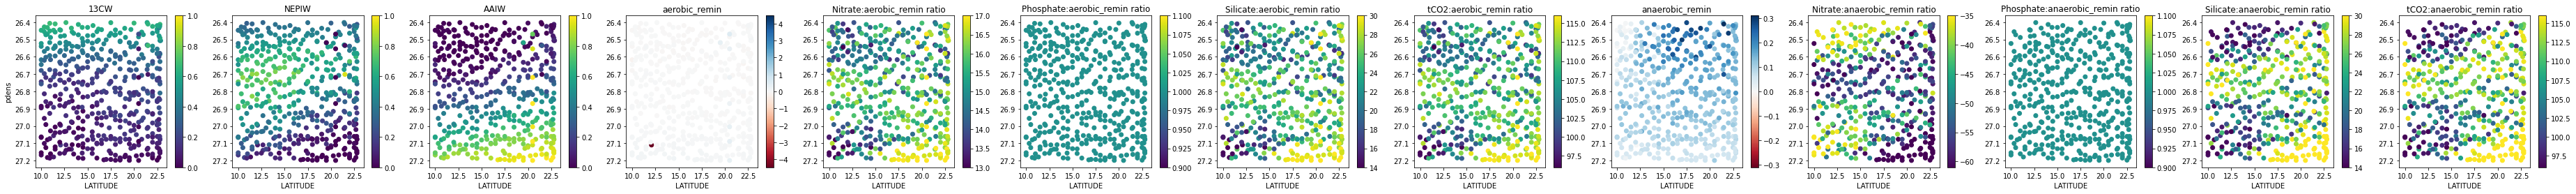

std


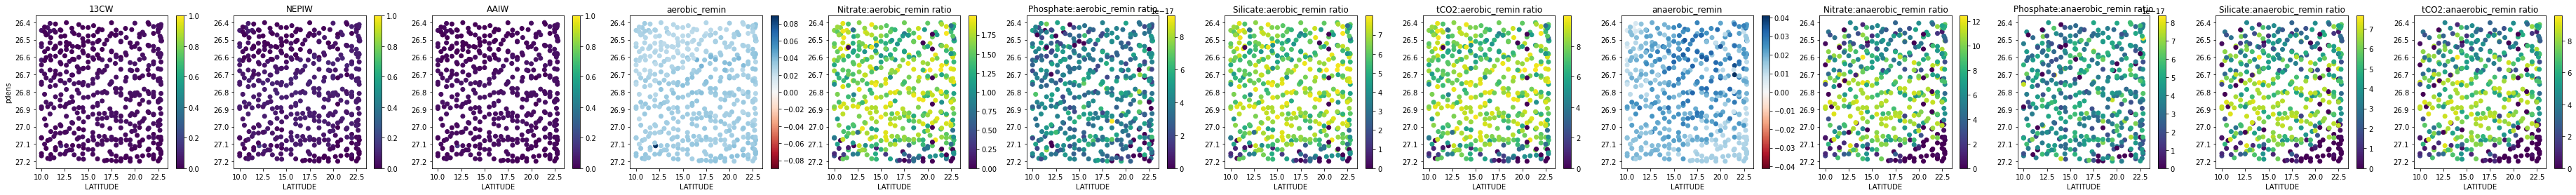

In [75]:
#plot the solutions

mean_skeleton_endmembers, std_skeleton_endmembers = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")

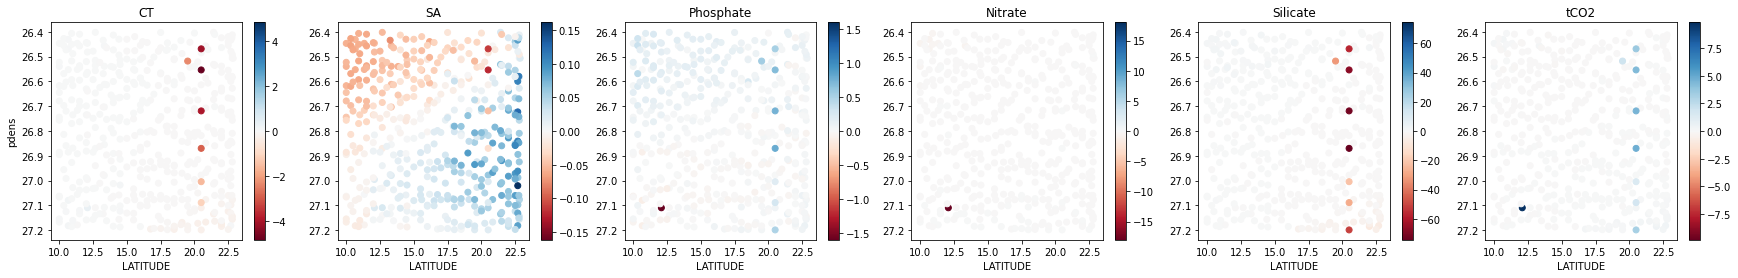

std


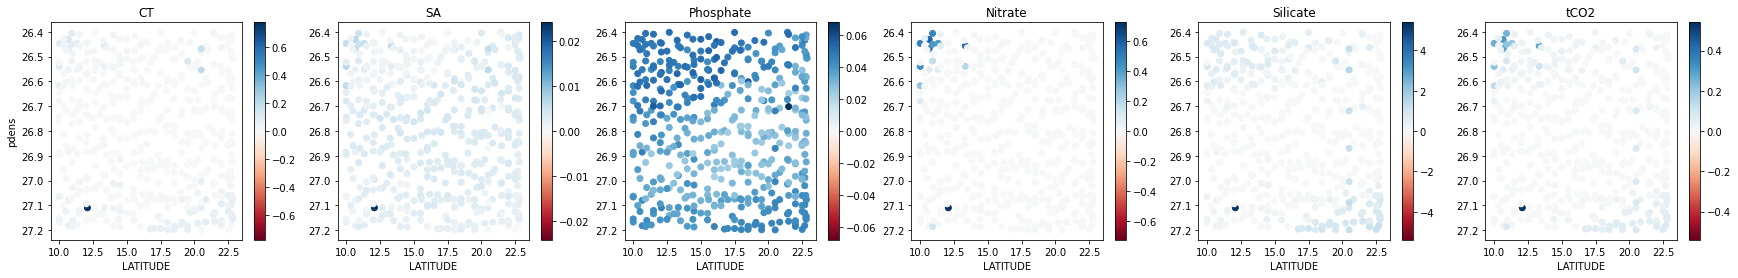

In [77]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")

Sensitivity with regards to weightings

In [81]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 10
base_weighting = paramweightings

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.1)) # lowered max values from 1.2 to 1.1 to prevent an error
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_df": endmembers_df,
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})


mkdir: cannot create directory ‘param_weightings_sensitivity’: File exists
On varying argument 0 out of 10
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'CT': 13.79325517697805, 'SA': 10.736368659299462, 'Phosphate': 8.29725791933688, 'Nitrate': 8.780995518852068, 'tCO2': 4.35056211458344, 'Silicate': 2.075178481174984}}, solve_arguments={})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [13.79325518 10.73636866  8.29725792  8.78099552  2.07517848  4.35056211]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 457
status: optimal
optimal value 1187.1465524686491
Original weighted sum squares: 1187.146204365828
Post fix weighted sum squared: 1187.3450053093102
On example 100 to 200 out of 457
status: optimal
optimal value 1401.018092610132
Original weighted sum squares:

mean


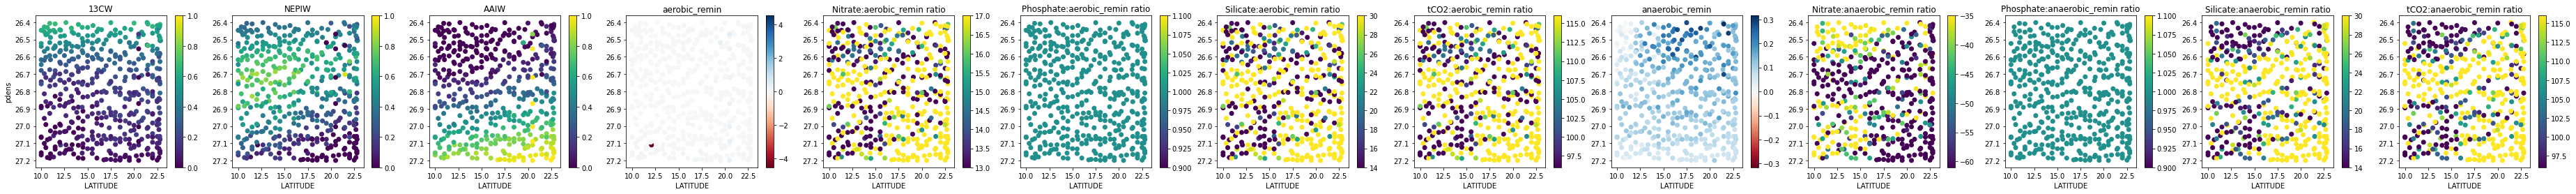

std


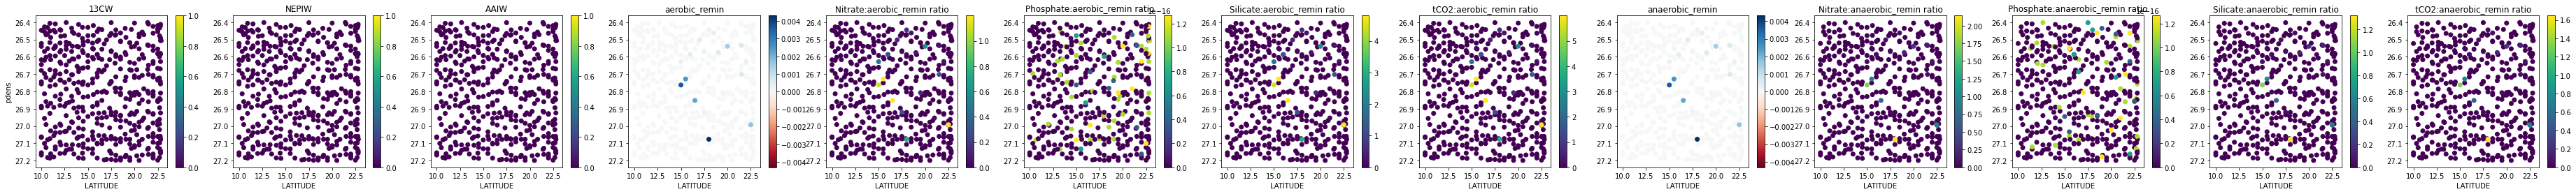

In [82]:
#plot the solutions

mean_skeleton_weightings, std_skeleton_weightings = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_weightings,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_weightings,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")

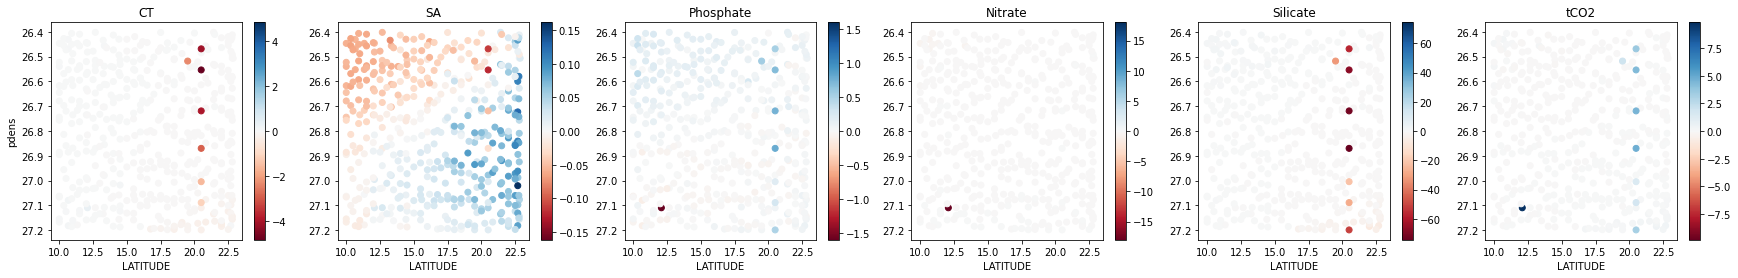

std


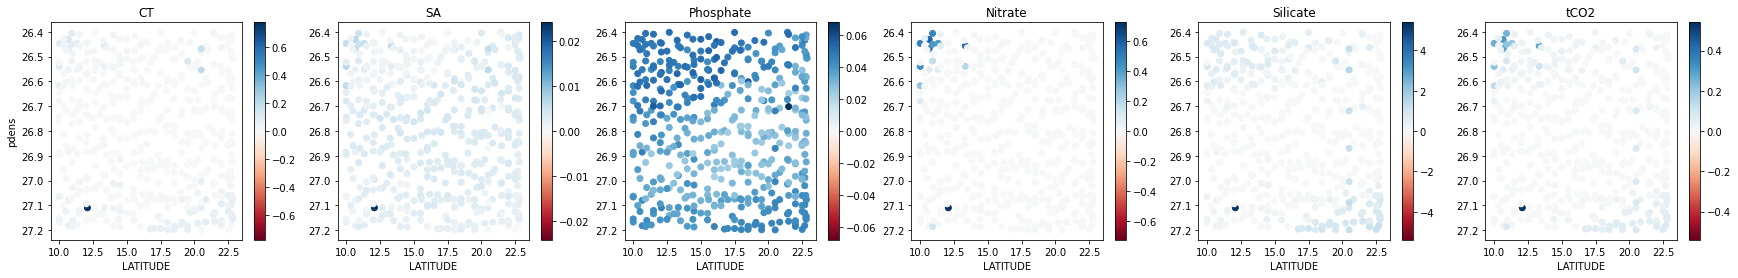

In [83]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="LATITUDE",
                                  yaxis_colname="pdens")

In [84]:
###uncomment below to export csv with senstivity analysis info###

%cd "/content/drive/MyDrive/USC drive/pyompa/ETNP WOD pyompa"

ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
mean_skeleton_endmembers.export_to_csv(
    csv_output_name="mean_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_endmembers.export_to_csv(
    csv_output_name="std_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

mean_skeleton_weightings.export_to_csv(
    csv_output_name="mean_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_weightings.export_to_csv(
    csv_output_name="std_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

/content/drive/MyDrive/USC drive/pyompa/ETNP WOD pyompa
writing to mean_skeleton_endmembers.csv
writing to std_skeleton_endmembers.csv
writing to mean_skeleton_weightings.csv
writing to std_skeleton_weightings.csv
